In [2]:
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from numpy.random import shuffle
import pandas as pd
import nltk,string
from gensim import corpora

In [3]:
#load reviews for wordvector training
train=pd.read_csv("wordvector_train.csv",header=0,delimiter="\t")
train.head()

,Reviews
0,Pretty standard Chinese food
1,Never had a bad experience here--it tastes j...
2,"When we sat down i had one thing on my mind ""..."
3,But it was okay
4,What really made my night was the STUPENDOUS ...


In [6]:
#load parsed dataset for aspect and sentiment prediction
predict=pd.read_csv("data_predict.csv",header=-1,delimiter=",")
predict.head()

,0,1,2,3
0,bid,reviews,Cat,star
1,iFEiMJoEqyB9O8OUNSdLzA,Pretty standard Chinese food. Never had a bad...,"['Chinese', 'Restaurants']",3
2,HmI9nhgOkrXlUr6KZGZZew,This little diner is a staple in Bloomfield's ...,"['Sandwiches', 'Restaurants', 'Italian', 'Dine...",3
3,FLTbKRmBytP1AbjWSPEeyw,Ever since I had one of the best meals of my l...,"['Restaurants', 'Chinese']",4
4,58APdML-PG_OD4El2ePTvw,Location: Tucked away in the Old Port. The clo...,"['Restaurants', 'Specialty Food', 'French', 'B...",4


In [16]:
#load labelled aspect reviews for training 
aspect_l=pd.read_csv("labelled1.csv", header=0, delimiter=",")
aspect_l.head()

,Reviews,Aspects
0,Pretty standard Chinese food,food
1,Never had a bad experience here--it tastes j...,food
2,"When we sat down i had one thing on my mind ""...",food
3,But it was okay,food
4,What really made my night was the STUPENDOUS ...,food


In [17]:
#load labelled aspect reviews for training 
sentiment_l=pd.read_csv("labelled3.csv", header=0, delimiter=",")
sentiment_l.head()

,Reviews,sentiment
0,Pretty standard Chinese food,Neutral
1,Never had a bad experience here--it tastes j...,Positive
2,"When we sat down i had one thing on my mind ""...",Negative
3,I'll take the tortilla chips and cheesy salsa...,Neutral
4,But it was okay,Neutral


In [35]:
#convert labels into the form of "list of list"
labels1=[str(item["Aspects"]).split(",") for index, item in aspect_l.iterrows()]
labels2=[str(item["sentiment"]).split(",") for index, item in sentiment_l.iterrows()]
#create indicator matrix for labels
mlb1=MultiLabelBinarizer()
mlb2=MultiLabelBinarizer()
Y1=mlb1.fit_transform(labels1)
Y2=mlb2.fit_transform(labels2)
print("sample label of labelled aspects")
print(Y1[0:5])
print("sample label of labelled sentiments")
print(Y2[0:5])
#mlb1.classes_
#mlb2.classes_

sample label of labelled aspects
[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]
sample label of labelled sentiments
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]]


In [36]:
#tokenize reviews in wordvector_train.csv and prepare for word vector training
from gensim.models import word2vec
import logging
import pandas as pd
sentences=[ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in train['Reviews']]
print(sentences[0:2])

[['Pretty', 'standard', 'Chinese', 'food'], ['Never', 'had', 'bad', 'experience', 'here', 'it', 'tastes', 'just', 'like', 'you', 'expect', 'take', 'out', 'Chinese', 'to', 'taste']]


In [24]:
#word vector training process
# print out tracking information
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)
EMBEDDING_DIM=100
# min_count: words with total frequency lower than this are ignored
# size: the dimension of word vector
# window: is the maximum distance 
#         between the current and predicted word 
#         within a sentence (i.e. the length of ngrams)
# workers: # of parallel threads in training
# for other parameters, check https://radimrehurek.com/gensim/models/word2vec.html
wv_model = word2vec.Word2Vec(sentences, min_count=5, \
                             size=EMBEDDING_DIM, window=5, workers=4 )

2017-12-03 17:15:19,265 : INFO : collecting all words and their counts
2017-12-03 17:15:19,267 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-03 17:15:19,610 : INFO : PROGRESS: at sentence #10000, processed 960863 words, keeping 45009 word types
2017-12-03 17:15:19,937 : INFO : PROGRESS: at sentence #20000, processed 1949496 words, keeping 69358 word types
2017-12-03 17:15:20,271 : INFO : PROGRESS: at sentence #30000, processed 2930472 words, keeping 89602 word types
2017-12-03 17:15:20,659 : INFO : PROGRESS: at sentence #40000, processed 3932435 words, keeping 107932 word types
2017-12-03 17:15:20,716 : INFO : collected 110372 word types from a corpus of 4072390 raw words and 41447 sentences
2017-12-03 17:15:20,717 : INFO : Loading a fresh vocabulary
2017-12-03 17:15:21,030 : INFO : min_count=5 retains 21539 unique words (19% of original 110372, drops 88833)
2017-12-03 17:15:21,032 : INFO : min_count=5 leaves 3948389 word corpus (96% of original 407

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# get word vector for all words in the vocabulary

MAX_NB_WORDS=2000

# tokenizer.word_index provides the mapping 
# between a word and word index for all words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train["Reviews"])
NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))

# "+1" is for padding symbol
embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    # if word_index is above the max number of words, ignore it
    if i >= NUM_WORDS:
        continue
    if word in wv_model.wv:
        embedding_matrix[i]=wv_model.wv[word]

Using TensorFlow backend.


In [26]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

#cnn traning model function
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              EMBEDDING_DIM=100, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.5, \
              # dropout rate
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.01):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        weights=[PRETRAINED_WORD_VECTOR],\
                        trainable=False,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)

    z=Concatenate(name='concate')(conv_blocks)
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(192, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model

#name best models
BEST_MODEL_FILEPATH1="best_model1"
BEST_MODEL_FILEPATH2="best_model2"

69864
[('pretty', 5383), ('standard', 759), ('chinese', 2410), ('food', 27086), ('never', 5179)]


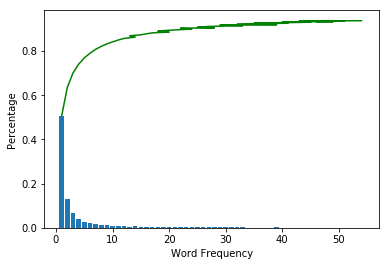

In [54]:
# Define MAX_NB_WORDS  
# Set MAX_NB_WORDS to include words that appear at least K times

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# total number of words
total_nb_words=len(tokenizer.word_counts)
print(total_nb_words)

print(list(tokenizer.word_counts.items())[0:5])
# put word and its counts into a data frame
word_counts=pd.DataFrame(\
            list(tokenizer.word_counts.items()), \
            columns=['word','count'])
word_counts.head(3)

# get histogram of word counts
# after reset index, "index" column 
# is the word frequency
# "count" column gives how many words appear at 
# a specific frequency
df=word_counts['count'].value_counts().reset_index()
df.head(3)

# convert absolute counts to precentage
df['percent']=df['count']/len(tokenizer.word_counts)
# get cumulative percentage
df['cumsum']=df['percent'].cumsum()
df.head(5)

# plot the chart
# then we decided to set MAX_NB_WORDS=2000
plt.bar(df["index"].iloc[0:50], df["percent"].iloc[0:50])
plt.plot(df["index"].iloc[0:50], df['cumsum'].iloc[0:50], c='green')

plt.xlabel('Word Frequency')
plt.ylabel('Percentage')
plt.show()

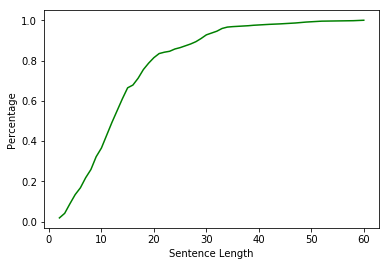

In [55]:
# Define MAX_DOC_LEN 
# Set MAX_DOC_LEN to include complete sentences as many as possible

# create a series based on the length of all sentences
sen_len=pd.Series([len(item) for item in sequences_aspect])

# create histogram of sentence length
# the "index" is the sentence length
# "counts" is the count of sentences at a length
df=sen_len.value_counts().reset_index().sort_values(by='index')
df.columns=['index','counts']
df.head(3)

# sort by sentence length
# get percentage and cumulative percentage

df=df.sort_values(by='index')
df['percent']=df['counts']/len(sen_len)
df['cumsum']=df['percent'].cumsum()
df.head(3)

# From the plot, 90% sentences have length<30, and for both aspect and sentiment dataset the plot performence is alike
# so we decided to set MAX_DOC_LEN=30 
plt.plot(df["index"], df['cumsum'], c='green')

plt.xlabel('Sentence Length')
plt.ylabel('Percentage')
plt.show()

In [71]:
#Fit aspect model using pretrained word vectors

from sklearn.model_selection import train_test_split

# set the number of output units
NUM_OUTPUT_UNITS=len(mlb1.classes_)

FILTER_SIZES=[2,3,4]

BTACH_SIZE = 64
NUM_EPOCHES = 100

# With well trained word vectors, sample size can be reduced
# We used 400 labeled aspect reviews
# split dataset into train (70%) and test sets (30%)
MAX_DOC_LEN=30
sequences_aspect = tokenizer.texts_to_sequences(aspect_l["Reviews"])
padded_sequences_aspect = pad_sequences(sequences_aspect, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')
#
sequences_1 = tokenizer.texts_to_sequences(predict[1])
padded_sequences_1 = pad_sequences(sequences_1, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

X_train, X_test, Y_train, Y_test = train_test_split(\
                padded_sequences_aspect[0:400], Y1[0:400], \
                test_size=0.3, random_state=0)

# create the model with embedding matrix
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, NUM_OUTPUT_UNITS, \
                PRETRAINED_WORD_VECTOR=embedding_matrix)

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH1, monitor='val_acc', \
                             verbose=2, save_best_only=True, mode='max')
    
training=model.fit(X_train, Y_train, \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[X_test, Y_test], verbose=2)

Train on 280 samples, validate on 120 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.78542, saving model to best_model1
1s - loss: 2.9609 - acc: 0.6464 - val_loss: 2.6193 - val_acc: 0.7854
Epoch 2/100
Epoch 00001: val_acc improved from 0.78542 to 0.79167, saving model to best_model1
0s - loss: 2.6174 - acc: 0.7571 - val_loss: 2.5070 - val_acc: 0.7917
Epoch 3/100
Epoch 00002: val_acc improved from 0.79167 to 0.80417, saving model to best_model1
0s - loss: 2.4190 - acc: 0.7723 - val_loss: 2.3541 - val_acc: 0.8042
Epoch 4/100
Epoch 00003: val_acc improved from 0.80417 to 0.81458, saving model to best_model1
0s - loss: 2.2813 - acc: 0.7946 - val_loss: 2.2320 - val_acc: 0.8146
Epoch 5/100
Epoch 00004: val_acc improved from 0.81458 to 0.82500, saving model to best_model1
0s - loss: 2.1972 - acc: 0.8054 - val_loss: 2.0921 - val_acc: 0.8250
Epoch 6/100
Epoch 00005: val_acc improved from 0.82500 to 0.83333, saving model to best_model1
0s - loss: 2.0776 - acc: 0.8214 - val_loss

In [78]:
# evaluate the accuracy of aspect CNN model
scores_1 = model.evaluate(padded_sequences_aspect, Y1, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores_1[1]*100))

acc: 94.27%


In [74]:
#Fit sentiment model using pretrained word vectors

# set the number of output units
# as the number of classes
NUM_OUTPUT_UNITS_1=len(mlb2.classes_)

FILTER_SIZES=[2,3,4]

BTACH_SIZE = 64
NUM_EPOCHES = 100

# With well trained word vectors, sample size can be reduced
# We use our 450 labeled sentiment reviews
# split dataset into train (70%) and test sets (30%)
MAX_DOC_LEN=30
sequences_sentiment = tokenizer.texts_to_sequences(sentiment_l["Reviews"])
padded_sequences_sentiment = pad_sequences(sequences_sentiment, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

#sequences_2 = tokenizer.texts_to_sequences(predict[1])
#padded_sequences_2 = pad_sequences(sequences_2, \
                                 #maxlen=MAX_DOC_LEN, \
                                 #padding='post', \
                                 #truncating='post')

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(\
                padded_sequences_sentiment[0:450], Y2[0:450], \
                test_size=0.3, random_state=0)

# create the model with embedding matrix
model_1=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, NUM_OUTPUT_UNITS_1, \
                PRETRAINED_WORD_VECTOR=embedding_matrix)

earlyStopping_1=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint_1 = ModelCheckpoint(BEST_MODEL_FILEPATH2, monitor='val_acc', \
                             verbose=2, save_best_only=True, mode='max')
    
training_1=model_1.fit(X_train_1, Y_train_1, \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping_1, checkpoint_1],\
          validation_data=[X_test_1, Y_test_1], verbose=2)

Train on 314 samples, validate on 135 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.66667, saving model to best_model2
1s - loss: 2.7983 - acc: 0.6401 - val_loss: 2.5048 - val_acc: 0.6667
Epoch 2/100
Epoch 00001: val_acc improved from 0.66667 to 0.75556, saving model to best_model2
0s - loss: 2.6630 - acc: 0.6486 - val_loss: 2.3363 - val_acc: 0.7556
Epoch 3/100
Epoch 00002: val_acc improved from 0.75556 to 0.76790, saving model to best_model2
0s - loss: 2.4516 - acc: 0.7219 - val_loss: 2.2552 - val_acc: 0.7679
Epoch 4/100
Epoch 00003: val_acc did not improve
0s - loss: 2.2846 - acc: 0.7335 - val_loss: 2.2065 - val_acc: 0.7605
Epoch 5/100
Epoch 00004: val_acc improved from 0.76790 to 0.78765, saving model to best_model2
0s - loss: 2.2349 - acc: 0.7314 - val_loss: 2.1189 - val_acc: 0.7877
Epoch 6/100
Epoch 00005: val_acc did not improve
0s - loss: 2.1368 - acc: 0.7643 - val_loss: 2.0825 - val_acc: 0.7827
Epoch 7/100
Epoch 00006: val_acc did not improve
0s - loss: 2.037

In [79]:
# evaluate the accuracy of sentiment CNN model
scores_2 = model_1.evaluate(padded_sequences_sentiment, Y2, verbose=0)
print("%s: %.2f%%" % (model_1.metrics_names[1], scores_2[1]*100))

acc: 94.28%


In [77]:
# check model configuration
print("model configuration of aspect model")
print(model.summary())
print("\n")
print("model configuration of sentiment model")
print(model_1.summary())

model configuration of aspect model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 30)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 30, 100)       200100      main_input[0][0]                 
____________________________________________________________________________________________________
conv_2 (Conv1D)                  (None, 29, 64)        12864       embedding[0][0]                  
____________________________________________________________________________________________________
conv_3 (Conv1D)                  (None, 28, 64)        19264       embedding[0][0]                  
_______________________________________________________

In [80]:
# Performance evaluation of aspect CNN
# Let's use samples[0:400]
# as an evaluation set
from sklearn.metrics import classification_report
pred_1=model.predict(padded_sequences_aspect[0:400])

Y_pred_1=np.matrix(pred_1)
Y_pred_1=np.where(Y_pred_1>0.5,1,0)
Y1=np.array(Y1)

Y_pred_1[0:10]
Y1[100:110]

#y = map(lambda x: int(x), y)
#answer = map(lambda x: int(x), answer)
print(classification_report(Y1[0:400], Y_pred_1, target_names=mlb1.classes_))

             precision    recall  f1-score   support

   ambience       1.00      0.82      0.90        66
       food       0.91      0.98      0.94       259
      price       1.00      0.46      0.63        37
   serivice       0.93      0.91      0.92        94

avg / total       0.93      0.90      0.91       456



In [81]:
# Performance evaluation of sentiment CNN
# Let's use samples[0:400]
# as an evaluation set
pred_2=model_1.predict(padded_sequences_sentiment[0:400])

Y_pred_2=np.matrix(pred_2)
Y_pred_2=np.where(Y_pred_2>0.5,1,0)
#Y=np.array(Y)

Y_pred_2[0:10]
Y2[100:110]

#y = map(lambda x: int(x), y)
#answer = map(lambda x: int(x), answer)
print(classification_report(Y2[0:400], Y_pred_2, target_names=mlb2.classes_))

             precision    recall  f1-score   support

   Negative       0.92      0.91      0.92       148
    Neutral       0.97      0.69      0.81        42
   Positive       0.93      0.92      0.93       210

avg / total       0.93      0.89      0.91       400



In [89]:
#Predict the unlabelled dataset with aspects, and save the result into a csv file
pred_11=model.predict(padded_sequences_1[0:10602])

#we chose a threshold of 0.3, because at 30% probability, every review can have a label, and some aspects that 
#could be mentioned but not mentioned a lot in the review could be reflected
Y_pred_11=np.matrix(pred_11)
Y_pred_11=np.where(Y_pred_11>0.3,1,0)

#name of each column
print(mlb1.classes_)
print(Y_pred_11[0:200])

result_1 = pd.DataFrame(Y_pred_11)
result_1.to_csv('output1.csv')

['ambience' 'food' 'price' 'serivice']
[[0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 

In [93]:
#Predict the unlabelled dataset with sentiments, and save the result into a csv file
pred_12=model_1.predict(padded_sequences_1[0:10602])
Y_pred_12=np.matrix(pred_12)
#print(Y_pred_12)
#Because each review can only have a sentiment as a whole, we chose sentiment with the highest probability for each reveiw 
#as its representitive sentiment. And the highest probability is converted to 1, others 0.
print((Y_pred_12 == Y_pred_12.max(axis=1)).astype(float))

result_2 = pd.DataFrame((Y_pred_12 == Y_pred_12.max(axis=1)).astype(float))
result_2.to_csv('output2.csv')

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 ..., 
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
